In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [19]:
# Load the data from the CSV file

output_directory = './img/'
df = pd.read_csv('output.csv')
df['Iteration'] = df['InputFileName'].str.extract(r'(\d+)-')

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/1905418236.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('output.csv')


# Monolithic vs Microservices Experiment

Calculating joules

$E=P.\Delta t$

`Joules = Watts * Time in Seconds`

# Todo
- Analyse Average Watts per iteration ✅
- Calculate Joules per iteration ✅
- Analyse Energy Consumption in Joules per Iteration ✅
- Break down Energy Consumption by Frontend and Backend
- Analyse Temperature per Iteration and compare to Energy Consumption
- Analyse C State per iteration



In [20]:
# Calculate the Joules for each file name
time_column = ''

for file_name in df['InputFileName'].unique():
    subset = df[df['InputFileName'] == file_name]

    # Sum the watts for the current file name
    # total_watts = subset['Watts'].sum()
    average_watts = subset['Watts'].mean()
    average_cpu = subset['CPU'].mean()
    average_temp = subset['TMEM'].mean()

    # Determine the relevant time column based on the file name
    if 'frontend' in file_name.lower():
        if subset['Architecture'].iloc[0] == 'mono':
            time_column = 'MonoFrontendDuration'
        else:
            time_column = 'MicroFrontendDuration'

    elif 'api' in file_name.lower():
        if subset['Architecture'].iloc[0] == 'mono':
            time_column = 'MonoBackendDuration'
        else:
            time_column = 'MicroBackendDuration'

    # Calculate Joules for the current file name
    # Average of all those watt values * 60 seconds
    df.loc[df['InputFileName'] == file_name, 'Average_Watts'] = average_watts
    df.loc[df['InputFileName'] == file_name, 'Average_CPU'] = average_cpu
    df.loc[df['InputFileName'] == file_name, 'Average_Temperature'] = average_temp
    df.loc[df['InputFileName'] == file_name, 'Joules'] = average_watts * subset[time_column]
    

In [21]:
def plot_scenario(df, scenario, output_directory, y_column='Average_Watts', y_lim=None, aggregation='mean'):
    df_copy = df[df['ScenarioPath'] == scenario]

    # Step 1: Extract iteration number
    df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)

    # Step 2: Group by 'Iteration' and 'Architecture' and calculate mean or sum of 'Average_Watts'
    if aggregation == 'mean':
        grouped_df = df_copy.groupby(['Iteration', 'Architecture'])[y_column].mean()
    elif aggregation == 'sum':
        grouped_df = df_copy.groupby(['Iteration', 'Architecture'])[y_column].sum()
    else:
        raise ValueError("Invalid aggregation method. Choose either 'mean' or 'sum'.")

    # Step 3: Reset index
    grouped_df = grouped_df.reset_index()

    # Step 4: Create line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped_df, x='Iteration', y=y_column, hue='Architecture')
    plt.title(f'{y_column.replace("_", " ")} ({aggregation}) over 30 iterations for Monolith and Microservice Architectures Scenario {scenario}')

    title = f'{y_column.lower()}_scenario_{scenario}_{aggregation}.png'
    if y_lim:
        plt.ylim(0, y_lim)
        title = f'{y_column.lower()}_scenario_{scenario}_{aggregation}_ylim_{y_lim}.png'

    plt.savefig(os.path.join(output_directory, title), bbox_inches='tight', dpi=300)
    plt.show()

In [22]:
def plot_all_scenarios(df, output_directory, y_column='Average_Watts', y_lim=None, aggregation='mean'):
    # Step 1: Extract iteration number
    df['Iteration'] = df['InputFileName'].str.extract('(\d+)').astype(int)

    # Step 2: Group by 'Iteration', 'Architecture', and 'ScenarioPath' and calculate mean or sum of 'Average_Watts'
    if aggregation == 'mean':
        grouped_df = df.groupby(['Iteration', 'Architecture', 'ScenarioPath'])[y_column].mean()
    elif aggregation == 'sum':
        grouped_df = df.groupby(['Iteration', 'Architecture', 'ScenarioPath'])[y_column].sum()
    else:
        raise ValueError("Invalid aggregation method. Choose either 'mean' or 'sum'.")

    # Step 3: Reset index
    grouped_df = grouped_df.reset_index()

    # Step 4: Create line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped_df, x='Iteration', y=y_column, hue='Architecture', style='ScenarioPath')
    plt.title(f'{y_column.replace("_", " ")} ({aggregation}) over 30 iterations for Monolith and Microservice Architectures')

    if y_lim:
        plt.ylim(0, y_lim)

    plt.savefig(os.path.join(output_directory, f'{y_column.lower()}_all_scenarios_{aggregation}.png'), bbox_inches='tight', dpi=300)
    plt.show()

In [23]:
def plot_architecture_types(df, output_directory, y_column='Average_Watts', y_lim=None, aggregation='mean'):
    # Step 1: Extract iteration number and architecture type
    df['Iteration'] = df['InputFileName'].str.extract('(\d+)').astype(int)
    df['Type'] = df['InputFileName'].str.extract('-(\w+-\w+)\.csv')

    # Step 2: Group by 'Iteration', 'Architecture', and 'Type' and calculate mean or sum of 'Average_Watts'
    if aggregation == 'mean':
        grouped_df = df.groupby(['Iteration', 'Architecture', 'Type'])[y_column].mean()
    elif aggregation == 'sum':
        grouped_df = df.groupby(['Iteration', 'Architecture', 'Type'])[y_column].sum()
    else:
        raise ValueError("Invalid aggregation method. Choose either 'mean' or 'sum'.")

    # Step 3: Reset index
    grouped_df = grouped_df.reset_index()

    # Step 4: Create line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped_df, x='Iteration', y=y_column, hue='Architecture', style='Type')
    plt.title(f'{y_column.replace("_", " ")} ({aggregation}) over 30 iterations for different architecture types')

    if y_lim:
        plt.ylim(0, y_lim)

    plt.savefig(os.path.join(output_directory, f'{y_column.lower()}_architecture_types_{aggregation}.png'), bbox_inches='tight', dpi=300)
    plt.show()

In [24]:
def plot_architecture_types_for_scenario(df, scenario, output_directory, y_column='Average_Watts', y_lim=None, aggregation='mean'):
    df_copy = df[df['ScenarioPath'] == scenario]

    # Step 1: Extract iteration number and architecture type
    df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)
    df_copy['Type'] = df_copy['InputFileName'].str.extract('-(\w+-\w+)\.csv')

    # Step 2: Group by 'Iteration', 'Architecture', and 'Type' and calculate mean or sum of 'Average_Watts'
    if aggregation == 'mean':
        grouped_df = df_copy.groupby(['Iteration', 'Architecture', 'Type'])[y_column].mean()
    elif aggregation == 'sum':
        grouped_df = df_copy.groupby(['Iteration', 'Architecture', 'Type'])[y_column].sum()
    else:
        raise ValueError("Invalid aggregation method. Choose either 'mean' or 'sum'.")

    # Step 3: Reset index
    grouped_df = grouped_df.reset_index()

    # Step 4: Create line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped_df, x='Iteration', y=y_column, hue='Type', style='Architecture')
    plt.title(f'{y_column.replace("_", " ")} ({aggregation}) over 30 iterations for different architecture types in Scenario {scenario}')

    if y_lim:
        plt.ylim(0, y_lim)

    plt.savefig(os.path.join(output_directory, f'{y_column.lower()}_architecture_types_scenario_{scenario}_{aggregation}.png'), bbox_inches='tight', dpi=300)
    plt.show()

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/1859675840.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)
/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/1859675840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Type'] = df_copy['InputFileName'].str.extract('-(\w+-\w+)\.csv')


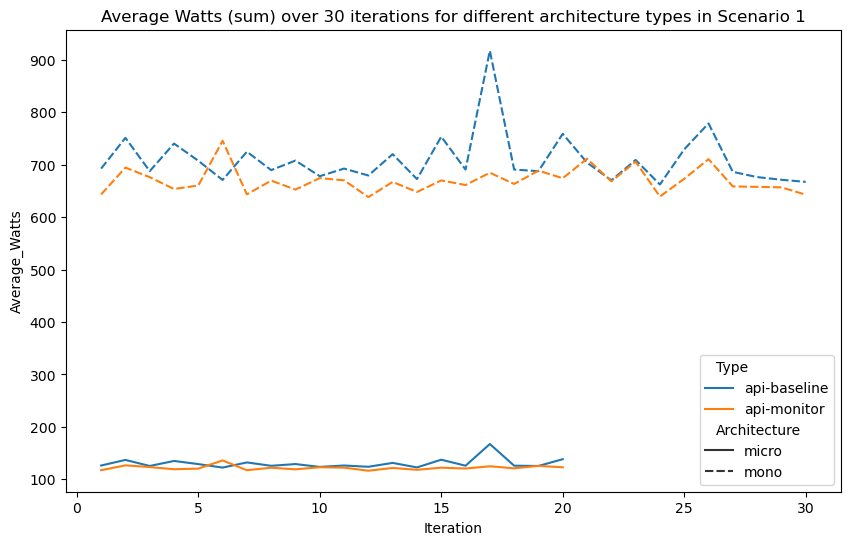

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/1859675840.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)
/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/1859675840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Type'] = df_copy['InputFileName'].str.extract('-(\w+-\w+)\.csv')


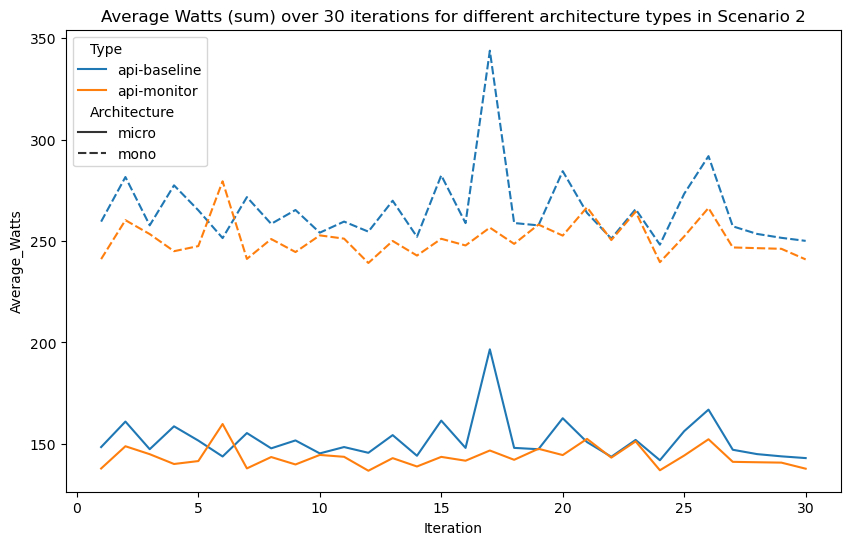

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/1859675840.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)
/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/1859675840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Type'] = df_copy['InputFileName'].str.extract('-(\w+-\w+)\.csv')


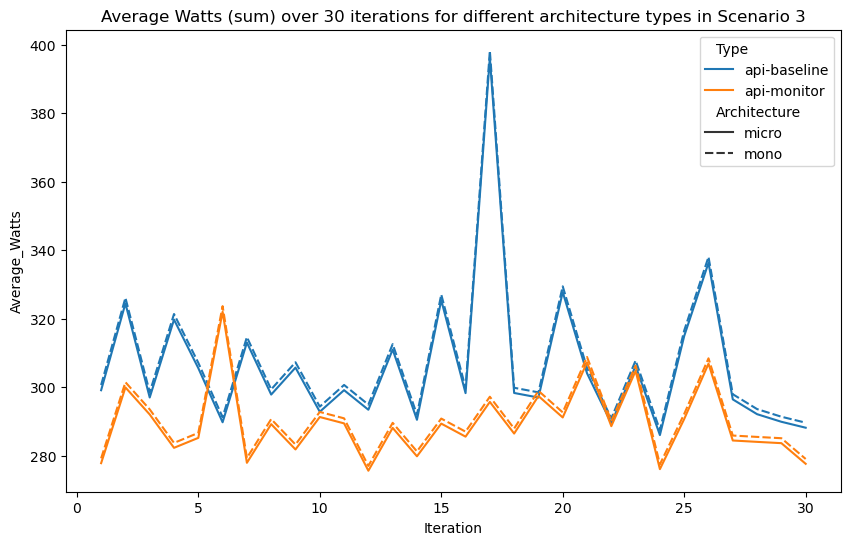

In [25]:
# Call the function for each scenario
for scenario in range(1, 4):
    # plot_scenario(df, scenario, output_directory, 'Average_Watts', aggregation='mean')
    # plot_scenario(df, scenario, output_directory, 'Average_Watts', aggregation='sum')
    plot_architecture_types_for_scenario(df, scenario, output_directory, 'Average_Watts', aggregation='sum')
    
# plot_architecture_types(df, output_directory, 'Average_Watts', aggregation='mean')

# plot_all_scenarios(df, output_directory, 'Average_Watts', aggregation='mean')
# plot_all_scenarios(df, output_directory, 'Average_Watts', aggregation='sum')

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


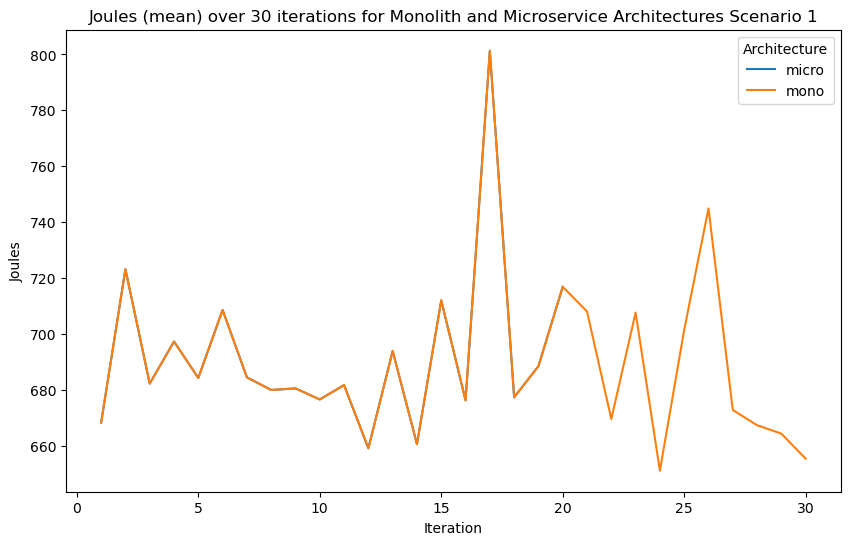

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


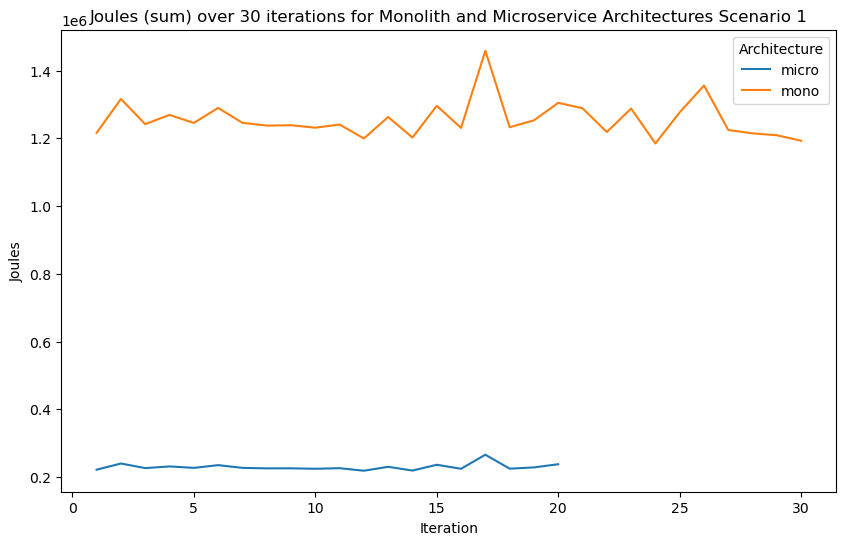

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


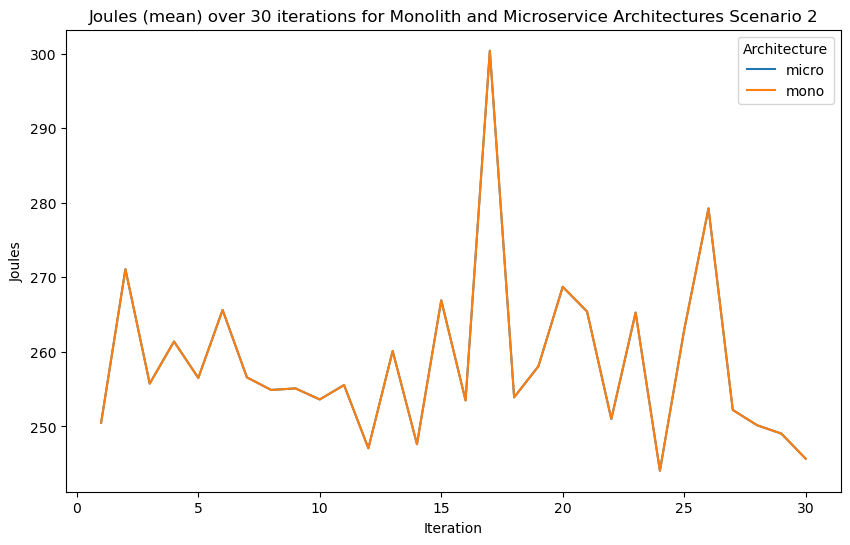

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


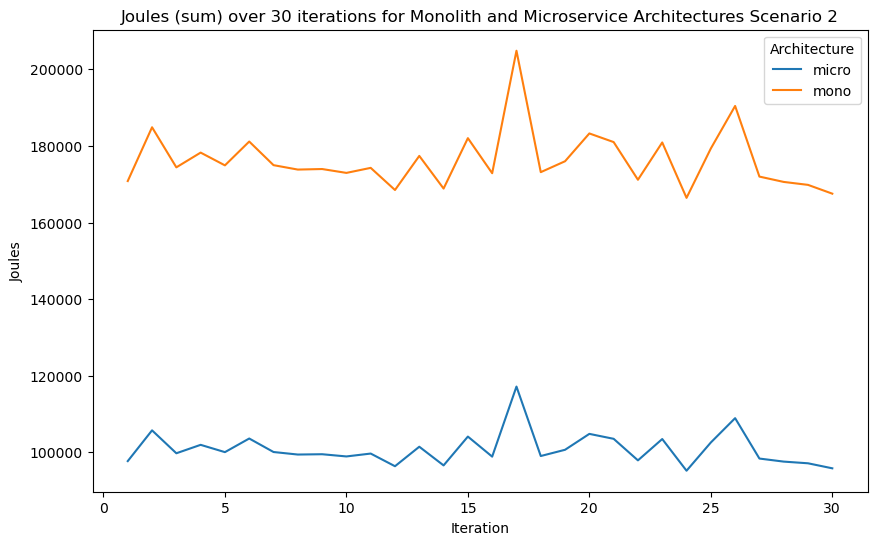

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


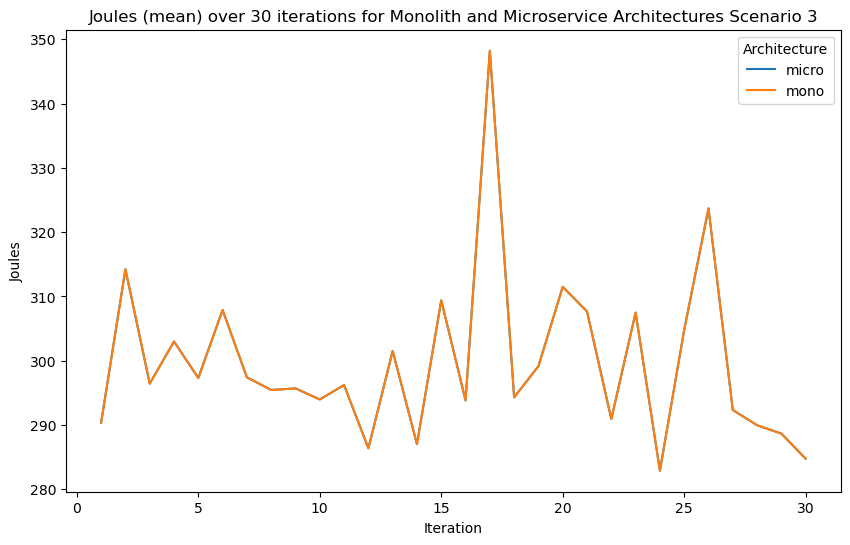

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


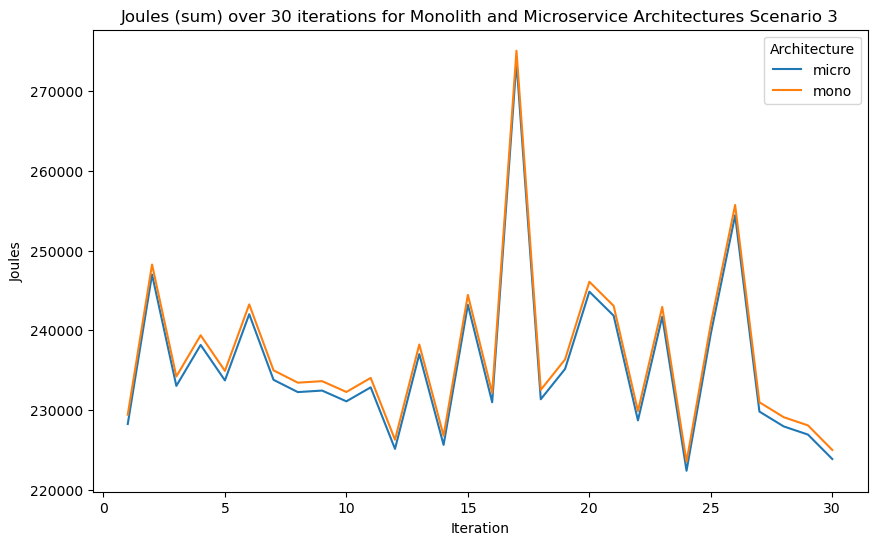

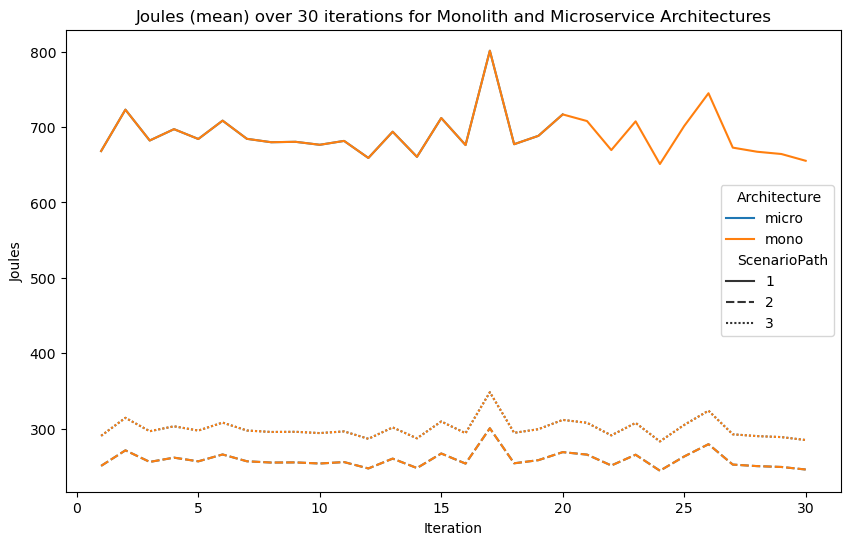

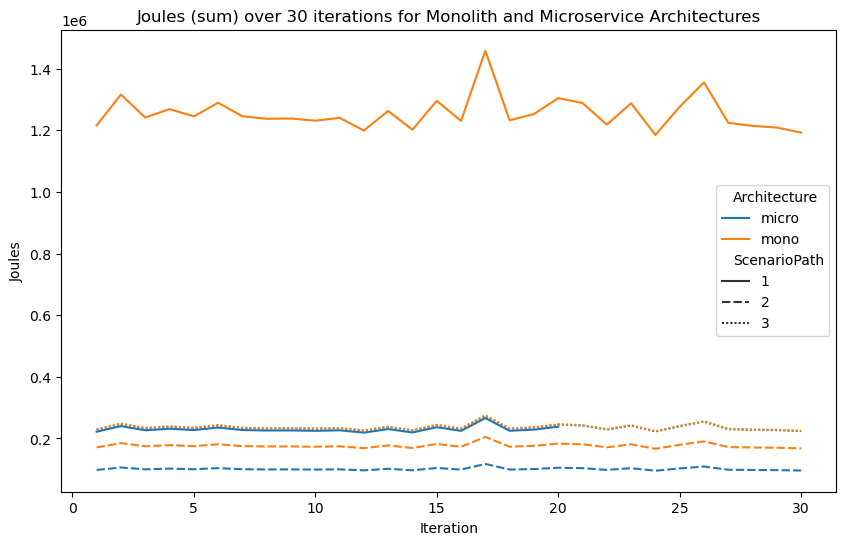

In [26]:
# Call the function for each scenario
for scenario in range(1, 4):
    plot_scenario(df, scenario, output_directory, 'Joules', aggregation='mean')
    plot_scenario(df, scenario, output_directory, 'Joules', aggregation='sum')

plot_all_scenarios(df, output_directory, 'Joules', aggregation='mean')
plot_all_scenarios(df, output_directory, 'Joules', aggregation='sum')

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


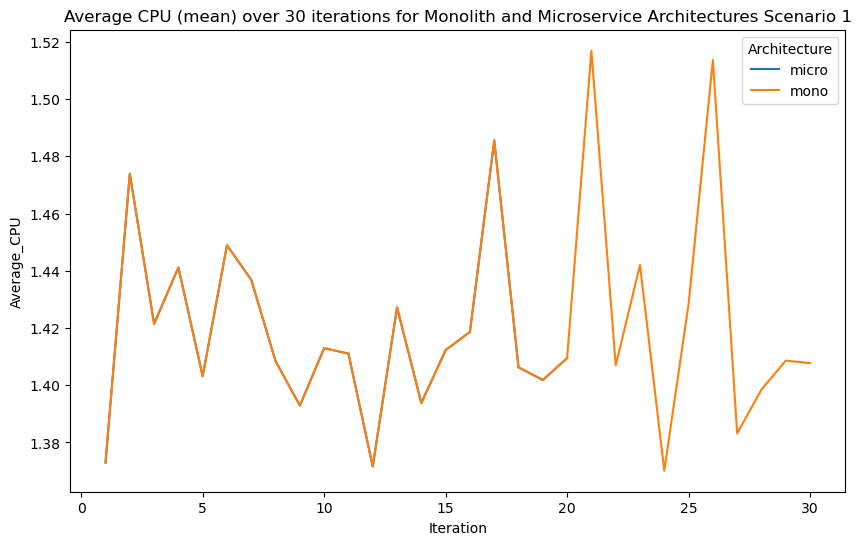

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


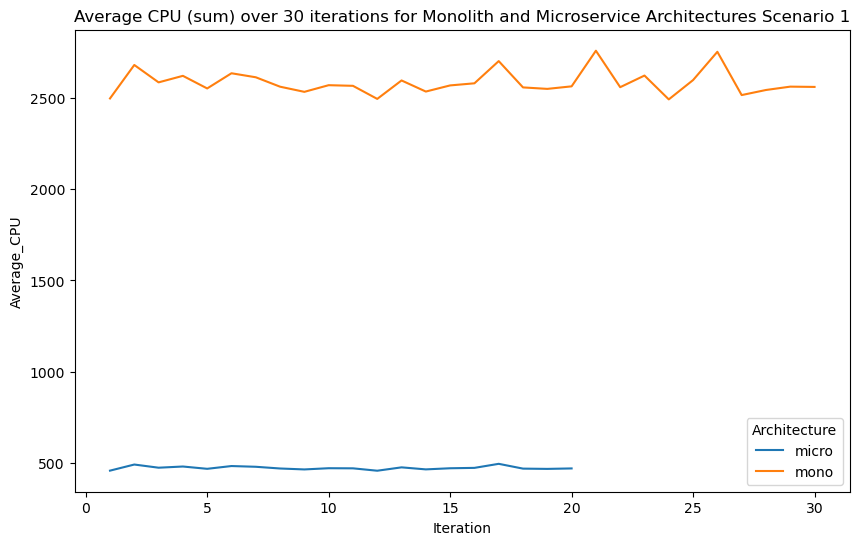

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


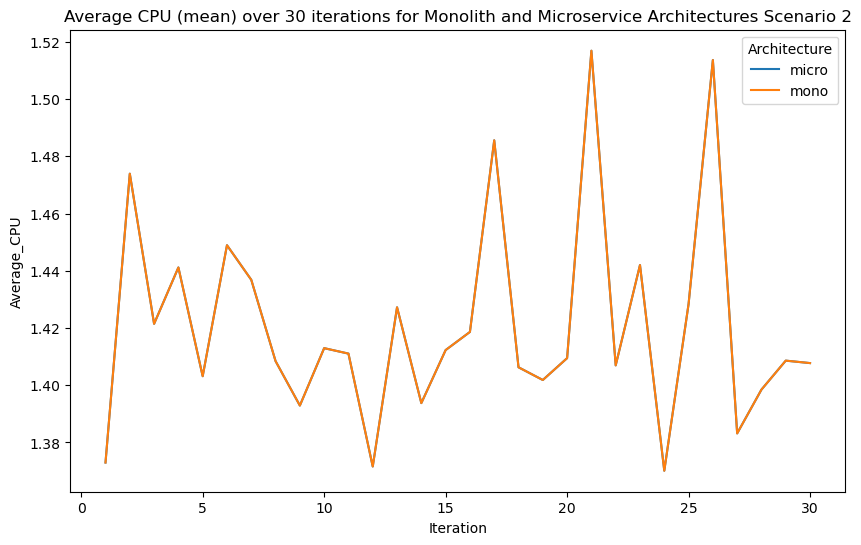

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


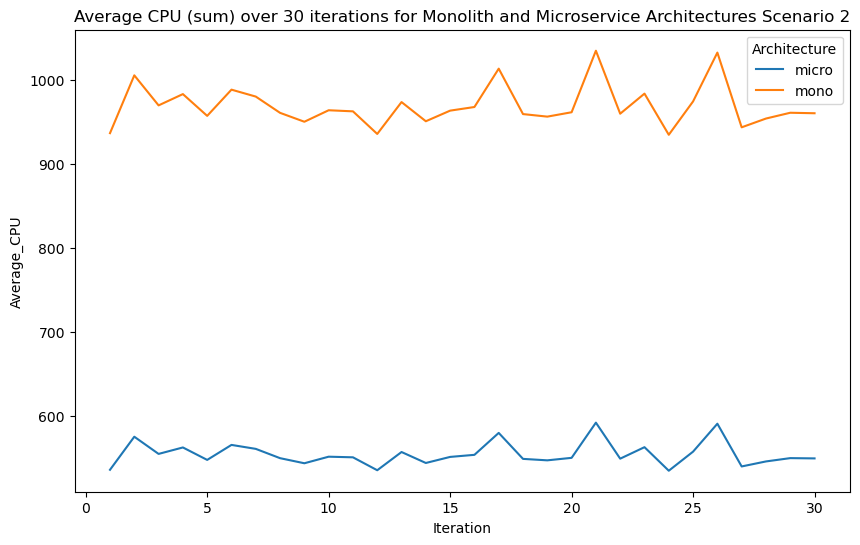

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


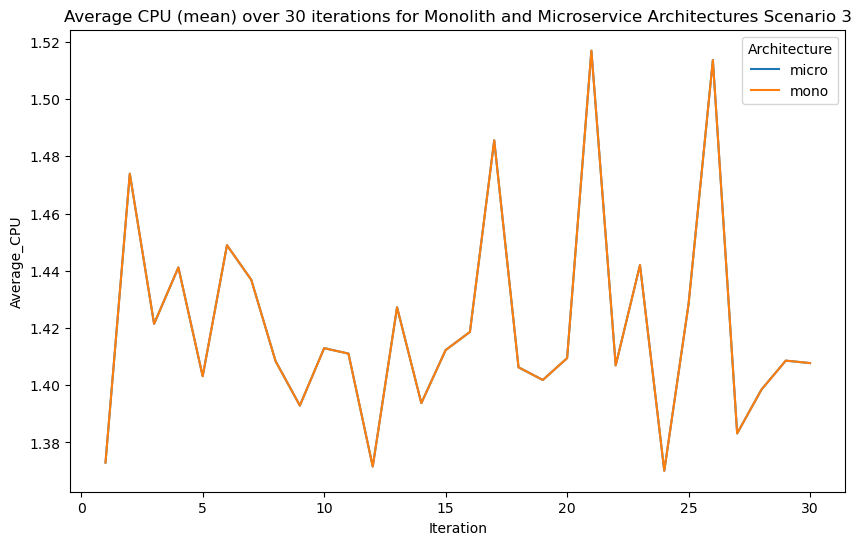

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_57127/3553808328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


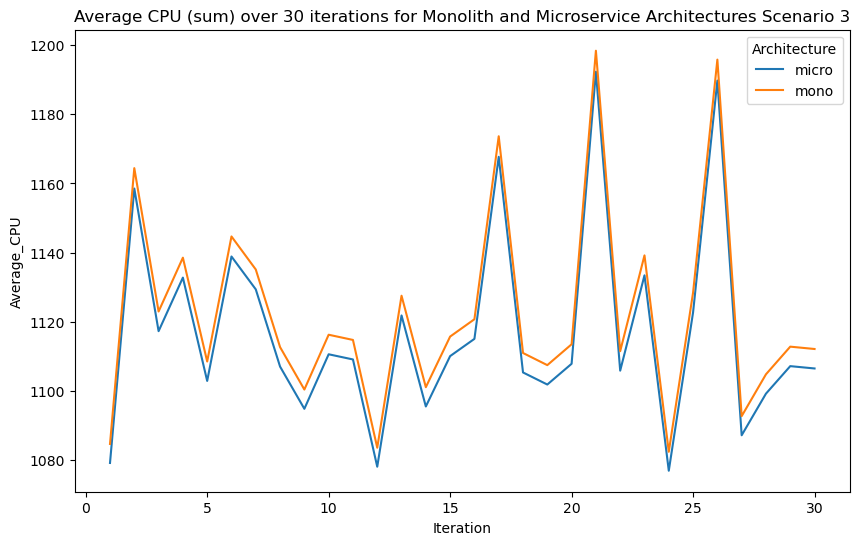

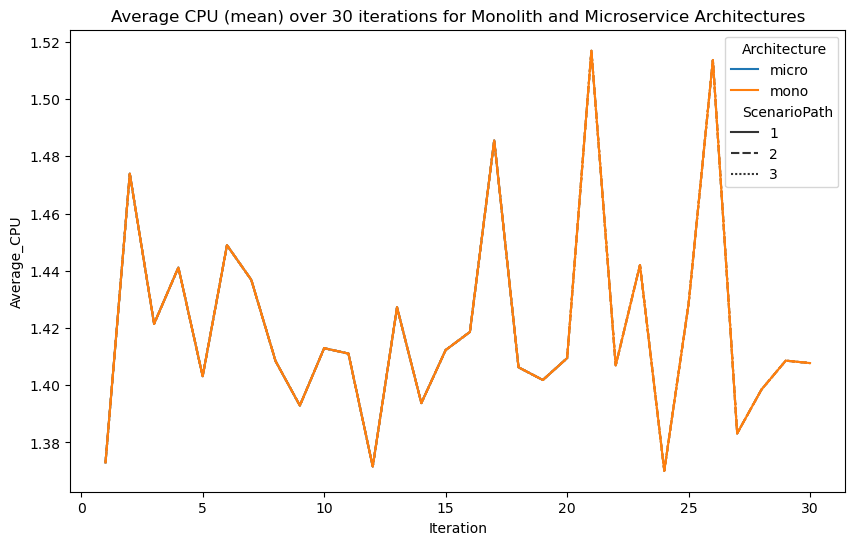

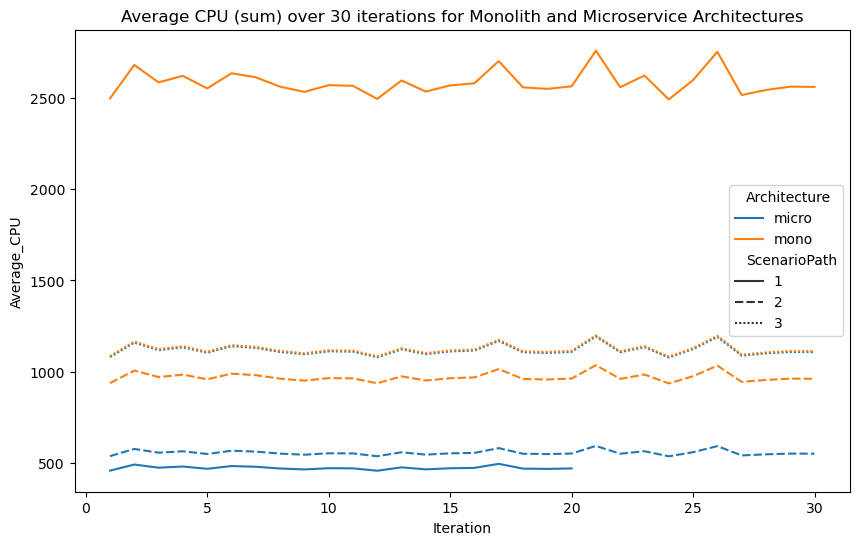

In [27]:
# Call the function for each scenario
for scenario in range(1, 4):
    plot_scenario(df, scenario, output_directory, 'Average_CPU', aggregation='mean')
    plot_scenario(df, scenario, output_directory, 'Average_CPU', aggregation='sum')

plot_all_scenarios(df, output_directory, 'Average_CPU', aggregation='mean')
plot_all_scenarios(df, output_directory, 'Average_CPU', aggregation='sum')

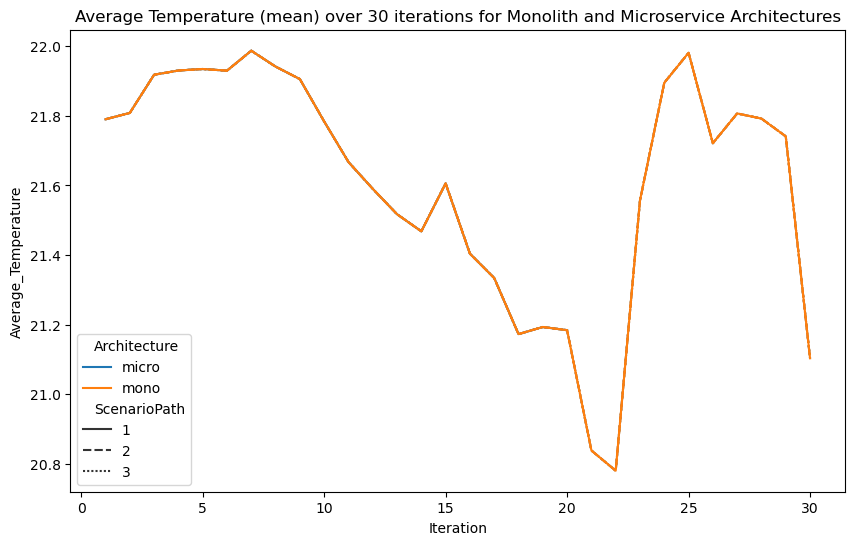

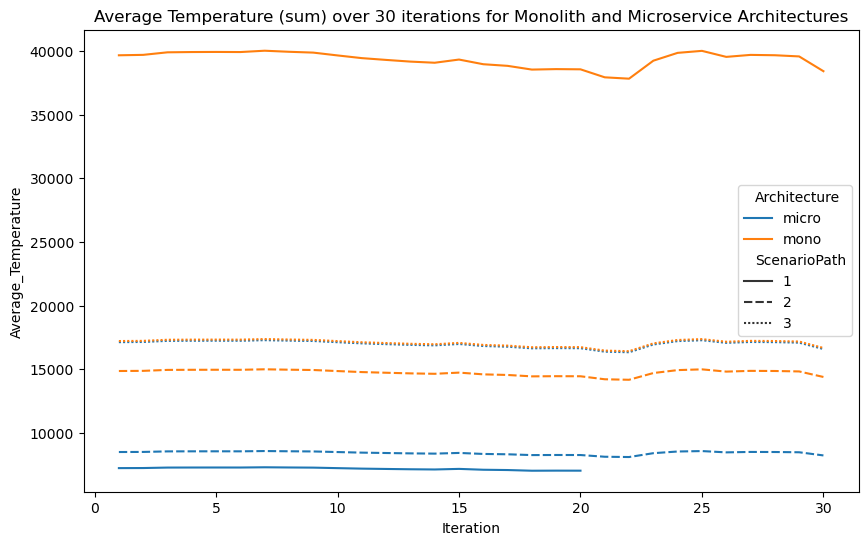

In [28]:
plot_all_scenarios(df, output_directory, 'Average_Temperature', aggregation='mean')
plot_all_scenarios(df, output_directory, 'Average_Temperature', aggregation='sum')